<a href="https://colab.research.google.com/github/Sofigam00s/Aprendizaje-Automatico-2-IA/blob/main/Gamallo_RL_TP2_entorno_merge_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico n°5 Aprendizaje por Refuerzo Merge v0

**Alumna: Sofia Antonia Gamallo**


---
## Entorno elegido: merge-v0


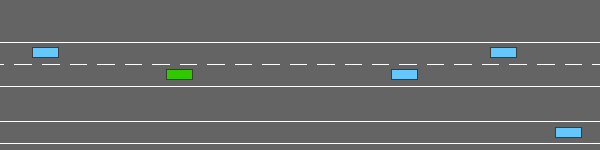

Merge-v0 es un entorno donde *"el vehículo propio parte de una carretera principal, pero pronto llega a un cruce con vehículos que se incorporan por la rampa de acceso. El objetivo del agente es ahora mantener una velocidad elevada mientras deja espacio para que los vehículos puedan incorporarse al tráfico de forma segura."*


https://highway-env.farama.org/environments/merge/

---


## Instalación de librerías

In [ ]:
!pip install highway-env

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import highway_env
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
import seaborn as sns
import math
import os
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

## Semilla para asegurar reproduciilidad

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2.1 Detalles del entorno

Merge es un entorno donde el agente conduce un auto por una autopista que en determinado momento se incorporan mas vehículos desde una rampa lateral. El objetivo del agente es conducir el vehículo sin chocarse y permtir que los vehiculos de la rampa lateral puedan entrar a la autopista sin problemas.

* **Observaciones:**
  El tipo de observación que utiliza merge se llama TimeToCollision y representa el riesgo de colisión/choque con vehículos cercanos en función del tiempo estimado que falta para impactar si se mantiene la velocidad actual.
  La observación está dentro de un espacio continuo, esto quiere decir que hay infinitas posibibilidades de estados (al contrario con frozen lake que solo hay 16). Estos estados tienen una matirz 5x5 en la que cada celda guarda lo siguiente:
    * vehículos que están adelante del agente
    * vehículos detrás
    * autos en carriles laterales
    * su velocidad relativa
    * estimación de tiempo para colisionar

* **Acciones:**
  Merge utiliza el tipo de acción DiscreteMetaAction que genera un espacio discreto de cinco acciones:
    Acción | Nombre | Descripción
    -------|--------|------------
    0 | IDLE | Mantener la velocidad y el carril
    1 | FASTER | Acelerar
    2 | SLOWER | Frenar o desacelerar
    3 | LANE_LEFT | Cambiarl al carril izquierdo
    4 | LANE_RIGTH | Cambiar al carril derecho

* **Recompensas:**
  Las recompensas de merge se encuentran en su código fuente dentro de una clase(https://highway-env.farama.org/_modules/highway_env/envs/merge_env/#MergeEnv.default_config)

  Esta clase contiene los siguientes componentes que corresponden a las recompensas:
  * **Recompensa por velocidad:** `reward_speed_range = [20, 30] `cuanto más cerca esté la velocidad del agente a 30, mayor la recompensa.
  * **Recompensa por estar en el carril derecho:** `right_lane_reward = 0.1 `favorece mantenerse hacia la derecha, como en conducción real.
  * **Recompensa por alta velocidad:** `high_speed_reward = 0.2`.
  * **Penalización por colisión:** `collision_reward = -1`.
  * **Penalización altruista (merge lane):** `merging_speed_reward = -0.5` si un vehículo de la rampa lateral no puede alcanzar su velocidad objetivo porque el agente bloquea la vía, se le castiga.
  * **Penalización por cambio de carril:** `lane_change_reward = -0.05 `desincentiva cambios de carril excesivos.

* **Condiciones de terminación:**
  El episodio termina cuando ocurre una colisión o cuando el vehículo para la zona objetivo `vehicle.position[0] > 370`.



## Creación del entorno

In [ ]:
# CREAR ENTORNO MERGE-V0 (configuración por defecto)
env = gym.make("merge-v0", render_mode="rgb_array")

# Semillas para reproducibilidad
env.reset(seed=42)
env.action_space.seed(42)
env.observation_space.seed(42)

print("🚗 ENTORNO MERGE-v0")
print("=" * 50)
print(f"Tipo de acciones: {env.action_space}")
print(f"Dimensión de la observación: {env.observation_space}")


🚗 ENTORNO MERGE-v0
Tipo de acciones: Discrete(5)
Dimensión de la observación: Box(-inf, inf, (5, 5), float32)


In [ ]:
obs, info = env.reset()
print("Estado inicial:\n", obs)
print("Forma del estado:", obs.shape)


Estado inicial:
 [[ 1.          0.15        0.5         0.375       0.        ]
 [ 1.          0.22133824  0.          0.01609663  0.        ]
 [ 1.          0.2814057   0.         -0.01374035  0.        ]
 [ 1.          0.4         1.         -0.125       0.        ]
 [ 0.          0.          0.          0.          0.        ]]
Forma del estado: (5, 5)


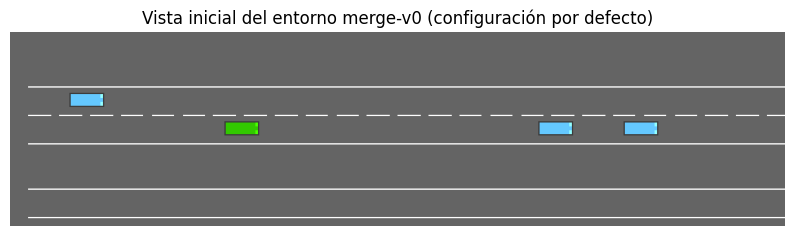

In [ ]:
frame = env.render()

plt.figure(figsize=(10, 4))
plt.imshow(frame)
plt.axis("off")
plt.title("Vista inicial del entorno merge-v0 (configuración por defecto)")
plt.show()




> Entonces, el entorno es el rectangulo de la carretera, el agente es el modelo que se entrena (política aleatoria, tabla q y dqn), las acciones los movimientos que realiza el agente, el estado en este caso es continuo y cambia constantemente deido a su movimiento. Por ultimo, el episodio terminá cuando el vehículo cocha o pasa una zona objetivo.



## 2.2 Implemetar una función para visualizar la política

Para poder visualizar la política opté por dos opciones. La primera es "simular" un entorno discreto para poder visualizar la política de cada modelo como se vió en el tp de FrozenLake. Si bien no se puede graficar un mapa o un entorno discreto en uno que es continuo, esta simluación permite ver el comportamiento que toma cada agente.

La segunda opción para entornos contunuos me la recomendó chatGPT, y es crear una función utilizacndo PCA, para poder ver las acciones que toma cada agente. En esta función se aplanan los datos (en este caso las acciones) que realizan los agentes y permite visualizar si pudieron aprender las similitudes entre cada acción, mientras más grupos definidios se encuentren en el gráfico, se puede decir que mejor esta aprendiendo el agente.

Para saber que acciones tiene y que número le corresponde, voy a usar la función *env.unwrapped.action_type.actions_indexes* que me muestra el orden y significado de cada una de ellas:

* 0 : cambiar al carril izquierdo
* 1 : mantener
* 2 : cambiar al carril derecho
* 3 : acelerar
* 4 : frenar

In [ ]:
print("Acciones del entorno y sus índices reales:")
print(env.unwrapped.action_type.actions_indexes)


Acciones del entorno y sus índices reales:
{'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


In [ ]:
def visualizar_politica_merge(policy, title="Política del Agente"):
    """
    Visualiza una política completa en forma de grilla 5x5 usando símbolos.
    policy debe ser una lista de acciones (0 a 4), una por cada posición del grid.
    """

    # Diccionario real de merge-v0
    simbolos = {
        0: "⇐",   # LANE_LEFT
        1: "•",   # IDLE
        2: "⇒",   # LANE_RIGHT
        3: "⇑",   # FASTER
        4: "⇓"    # SLOWER
    }

    # Asegurar tamaño 25 (5x5)
    policy = np.array(policy)
    if len(policy) < 25:
        # completamos con IDLE
        policy = np.pad(policy, (0, 25 - len(policy)), constant_values=1)

    grid = policy.reshape(5,5)

    plt.figure(figsize=(6,6))
    plt.imshow(np.ones((5,5)), cmap="Blues", alpha=0.2)

    for i in range(5):
        for j in range(5):
            a = grid[i,j]
            plt.text(j, i, simbolos[a], fontsize=26, ha="center", va="center")

    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.show()


In [ ]:
from sklearn.decomposition import PCA

def visualizar_politica_pca(estados, acciones, title="Política en espacio continuo (PCA)"):
    """
    Toma una lista de estados continuos y sus acciones asociadas,
    reduce los estados a 2D con PCA y grafica acción por color.
    """
    estados = np.array(estados).reshape(len(estados), -1)  # achatar 5x5 → 25
    acciones = np.array(acciones)

    pca = PCA(n_components=2)
    estados_2d = pca.fit_transform(estados)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(estados_2d[:,0], estados_2d[:,1],
                          c=acciones, cmap="tab10", s=12, alpha=0.8)

    plt.title(title, fontsize=16)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")

    cbar = plt.colorbar(scatter, ticks=[0,1,2,3,4])
    cbar.ax.set_yticklabels(["LEFT","IDLE","RIGHT","FASTER","SLOWER"])

    plt.grid(alpha=0.3)
    plt.show()


## 2.3 Entrenar modelos

### Política Aleatoria

Esta politica es igual a la del tp4 ya que para accionar, el agente tomá decisiones aleatorias, derivadas de la función seleccionar_accion con np.random.randint

In [ ]:
class PoliticaAleatoria:
    def __init__(self, env, nombre="Política Aleatoria"):
        self.env = env
        self.nombre = nombre
        self.n_acciones = env.action_space.n

        self.recompensas_entrenamiento = []
        self.exitos_entrenamiento = []
        self.loss_entrenamiento = []
        self.epsilon_entrenamiento = []
        self.pasos_entrenamiento = []

        self.recompensas_evaluacion = []
        self.exitos_evaluacion = []

        self.estados_tomados = []
        self.acciones_tomadas = []

    def seleccionar_accion(self, estado=None):
        """Selecciona una acción completamente al azar."""
        return np.random.randint(self.n_acciones)

    def entrenar(self, episodios=1000, max_steps=200):
        print(f"🎲 Entrenando {self.nombre}...")

        for ep in range(episodios):

            # ================================
            # 🔒 Reproducibilidad por episodio
            # ================================
            random.seed(SEED + ep)
            np.random.seed(SEED + ep)
            torch.manual_seed(SEED + ep)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(SEED + ep)
                torch.cuda.manual_seed_all(SEED + ep)

            # seed en el entorno
            estado, info = self.env.reset(seed=SEED + ep)

            terminado = False
            recompensa_total = 0
            pasos = 0

            for _ in range(max_steps):
                pasos += 1

                accion = self.seleccionar_accion(estado)

                # registrar
                self.estados_tomados.append(estado)
                self.acciones_tomadas.append(accion)

                estado, recompensa, terminado, truncado, info = self.env.step(accion)
                recompensa_total += recompensa

                if terminado or truncado:
                    break

            # EXITO = NO CHOCAR
            colision = info.get("crashed", False)
            exito = 0 if colision else 1

            # guardar métricas
            self.recompensas_entrenamiento.append(recompensa_total)
            self.exitos_entrenamiento.append(exito)
            self.pasos_entrenamiento.append(pasos)

            # valores fijos para política aleatoria
            self.epsilon_entrenamiento.append(1.0)
            self.loss_entrenamiento.append(0.0)

            if (ep + 1) % 200 == 0:
                print(
                    f"Episodio {ep+1}: "
                    f"Tasa éxito = {np.mean(self.exitos_entrenamiento[-200:]):.3f}, "
                    f"Recompensa = {np.mean(self.recompensas_entrenamiento[-200:]):.3f}, "
                    f"Pasos prom = {np.mean(self.pasos_entrenamiento[-200:]):.1f}, ")

        print(f"✅ Entrenamiento {self.nombre} completado.")

    def evaluar(self, episodios=200, max_steps=200):
        print(f"\n📊 Evaluando {self.nombre}...")
        self.recompensas_evaluacion = []
        self.exitos_evaluacion = []

        for ep in range(episodios):
            # =============================
            # 🔒 reproducibilidad
            # =============================
            random.seed(SEED + ep + 10000) # Usar una semilla diferente para evaluación
            np.random.seed(SEED + ep + 10000)
            torch.manual_seed(SEED + ep + 10000)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(SEED + ep + 10000)
                torch.cuda.manual_seed_all(SEED + ep + 10000)

            estado, info = self.env.reset(seed=SEED + ep + 10000)
            recompensa_total = 0

            for _ in range(max_steps):
                accion = self.seleccionar_accion(estado) # Siempre aleatorio para esta política
                estado, recompensa, terminado, truncado, info = self.env.step(accion)
                recompensa_total += recompensa

                if terminado or truncado:
                    break

            colision = info.get("crashed", False)
            exito = 0 if colision else 1

            self.recompensas_evaluacion.append(recompensa_total)
            self.exitos_evaluacion.append(exito)

        print(f"✔ Recompensa promedio = {np.mean(self.recompensas_evaluacion):.3f}")
        print(f"✔ Tasa de éxito = {np.mean(self.exitos_evaluacion):.3f}")

    @staticmethod
    def plot_politica_aleatoria_tiempo(acciones):
        """Grafica la secuencia temporal de acciones tomadas."""
        plt.figure(figsize=(12, 4))
        plt.plot(acciones, '.', alpha=0.6)
        plt.title("Política Aleatoria - Acciones tomadas")
        plt.xlabel("Paso de tiempo")
        plt.ylabel("Acción")
        # Configurar etiquetas del eje Y para que sean legibles
        plt.yticks([0, 1, 2, 3, 4], ["LEFT", "IDLE", "RIGHT", "FASTER", "SLOWER"])
        plt.grid(True, alpha=0.3)
        plt.show()

In [ ]:
politica_aleatoria = PoliticaAleatoria(env)

# Entrenamiento
politica_aleatoria.entrenar(episodios=1000)

# Evaluación
politica_aleatoria.evaluar(episodios=1000)

🎲 Entrenando Política Aleatoria...
Episodio 200: Tasa éxito = 0.190, Recompensa = 7.333, Pasos prom = 8.7, 
Episodio 400: Tasa éxito = 0.150, Recompensa = 7.356, Pasos prom = 8.8, 
Episodio 600: Tasa éxito = 0.140, Recompensa = 7.277, Pasos prom = 8.7, 
Episodio 800: Tasa éxito = 0.135, Recompensa = 7.388, Pasos prom = 8.9, 
Episodio 1000: Tasa éxito = 0.160, Recompensa = 7.232, Pasos prom = 8.6, 
✅ Entrenamiento Política Aleatoria completado.

📊 Evaluando Política Aleatoria...
✔ Recompensa promedio = 7.255
✔ Tasa de éxito = 0.156




> El modelo de política aleatoria tuvo una tasa de éxito del 15% y el episodio duró en prmedio 8 pasos.



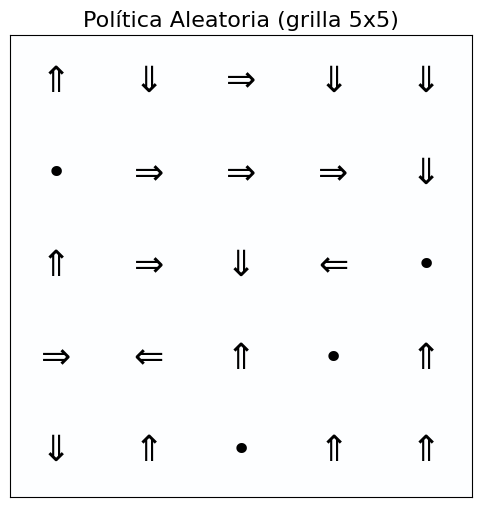

In [ ]:
# Visualización — política en grilla
policy_grid = politica_aleatoria.acciones_tomadas[:25]
visualizar_politica_merge(policy_grid, title="Política Aleatoria (grilla 5x5)")

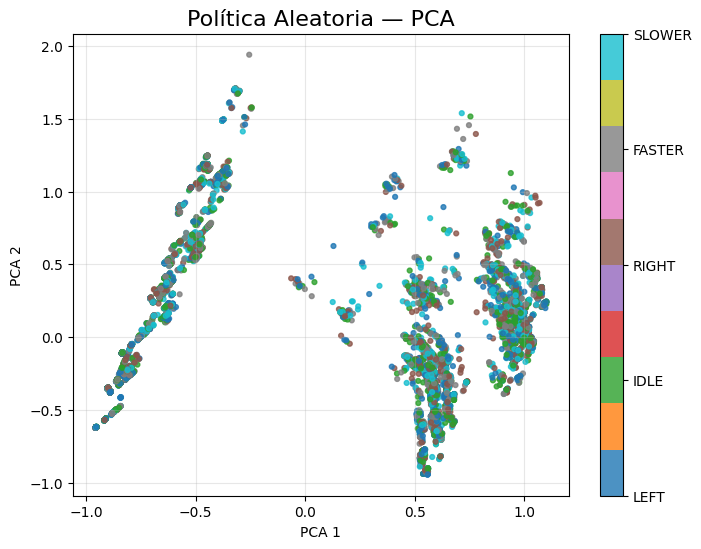

In [ ]:
# Visualización — política en espacio continuo (PCA)
visualizar_politica_pca(
    politica_aleatoria.estados_tomados,
    politica_aleatoria.acciones_tomadas,
    title="Política Aleatoria — PCA"
)

Este gráfico permite mostrar la capacidad de aprendizaje de modelo, en este caso se ven todas las acciones mezcladas y tomadas aleatoriamente sin ninguna lógica de aprendizaje.

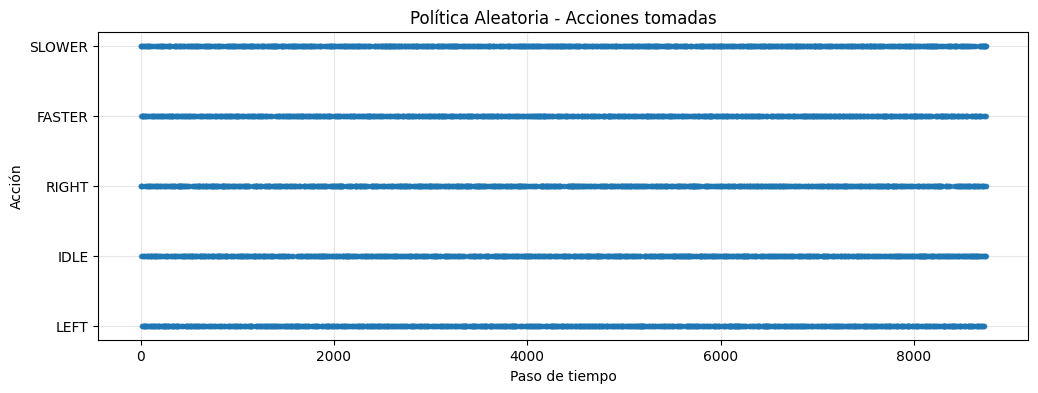

In [ ]:
# Visualización — secuencia temporal de acciones tomadas
PoliticaAleatoria.plot_politica_aleatoria_tiempo(
    politica_aleatoria.acciones_tomadas
)

Este gráfico permite ver como la política aleatoria ejecuta todas las acciones por igual sin buscar algún tipo de patron que mejore su tasa de éxito.

### Política Q-Learning Tabular:

Para esta política si tuve que implementar cambios ya que Q-learning tabular funciona muy bien para estados discretos, es decir, para un numero determinado de estados. En cambio, para estados continuos se debe **discretizar el estado para poder construir la tabla Q**

El entorno merge tiene una matriz 5x5 de valores continuos. Esta matriz con estos valores no puede leerla la tabla Q, por eso hay que implementar los siguientes pasos:
  * Aplanar la matriz.
  * Dividir los valores continuos en bins.
  * Convertir el vactor discretizado en un indice entero para la tabla Q.

Para realizar esta política me base del siguiente tutorial: https://phuijse.github.io/MachineLearningBook/contents/reinforcement_learning/qlearning2.html

Y con ayuda de chatGPT lo adapté al entorno de merge-v0.

In [ ]:
class QLearningAgent:
    def __init__(self, env, nombre="Q-Learning Merge"):
        self.env = env
        self.nombre = nombre

        # configuraciones Q-learning
        self.lr = 0.1
        self.gamma = 0.99

        # ε-greedy
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995

        # acciones
        self.n_acciones = env.action_space.n

        # Q-table basada en HASH del estado
        self.Q = {}

        # Métricas
        self.recompensas_entrenamiento = []
        self.exitos_entrenamiento = []
        self.loss_entrenamiento = []
        self.epsilon_hist = []
        self.pasos_entrenamiento = []

        # Para PCA
        self.estados_tomados = []
        self.acciones_tomadas = []

    # ----------------------------------------------------------
    # 🔧 Discretización
    # ----------------------------------------------------------
    def _discretizar(self, obs):
        """
        Convertimos la observación continua en un hash.
        """
        obs = np.round(obs, 1)
        return tuple(obs.flatten())

    def _get_Q(self, estado):
        if estado not in self.Q:
            self.Q[estado] = np.zeros(self.n_acciones)
        return self.Q[estado]

    # ----------------------------------------------------------
    def seleccionar_accion(self, estado):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_acciones)
        return np.argmax(self._get_Q(estado))

    # ----------------------------------------------------------
    def entrenar(self, episodios=1000, max_steps=200):

        print(f"📘 Entrenando {self.nombre}...")

        for ep in range(episodios):

            # =============================
            # 🔒 reproducibilidad
            # =============================
            random.seed(SEED + ep)
            np.random.seed(SEED + ep)
            torch.manual_seed(SEED + ep)

            estado_raw, info = self.env.reset(seed=SEED + ep)
            estado = self._discretizar(estado_raw)

            recompensa_total = 0
            pasos = 0
            losses_ep = []
            terminado = False

            for _ in range(max_steps):
                pasos += 1

                accion = self.seleccionar_accion(estado)

                # registrar PCA
                self.estados_tomados.append(estado_raw)
                self.acciones_tomadas.append(accion)

                estado_raw2, recompensa, terminado, truncado, info = self.env.step(accion)
                estado2 = self._discretizar(estado_raw2)

                recompensa_total += recompensa
                colision = info.get("crashed", False)

                q_vals = self._get_Q(estado)
                q_next = 0 if terminado else np.max(self._get_Q(estado2))

                old_q = q_vals[accion]

                # TD target
                td_target = recompensa + self.gamma * q_next
                td_error = td_target - old_q

                # update
                q_vals[accion] += self.lr * td_error

                losses_ep.append(abs(td_error))  # pérdida estimada

                estado = estado2
                estado_raw = estado_raw2

                if terminado or truncado:
                    break

            # =============================
            # Métricas del episodio
            # =============================
            exito = 0 if colision else 1

            self.recompensas_entrenamiento.append(recompensa_total)
            self.exitos_entrenamiento.append(exito)
            self.pasos_entrenamiento.append(pasos)
            self.loss_entrenamiento.append(np.mean(losses_ep))
            self.epsilon_hist.append(self.epsilon)

            # decay de epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if (ep + 1) % 200 == 0:
                print(
                    f"Episodio {ep+1}: "
                    f"Tasa éxito = {np.mean(self.exitos_entrenamiento[-200:]):.3f}, "
                    f"Recompensa = {np.mean(self.recompensas_entrenamiento[-200:]):.3f}, "
                    f"Pasos prom = {np.mean(self.pasos_entrenamiento[-200:]):.1f}, "
                )

        print("✅ Entrenamiento Q-Learning completado.")

    # ----------------------------------------------------------
    def evaluar(self, episodios=200):
        self.recompensas_evaluacion = []
        self.exitos_evaluacion = []

        for ep in range(episodios):
            estado_raw, info = self.env.reset(seed=SEED + ep)
            estado = self._discretizar(estado_raw)

            recompensa_total = 0

            for _ in range(200):
                accion = np.argmax(self._get_Q(estado))

                estado_raw, recompensa, terminado, truncado, info = self.env.step(accion)
                estado = self._discretizar(estado_raw)
                recompensa_total += recompensa

                if terminado or truncado:
                    break

            colision = info.get("crashed", False)
            exito = 0 if colision else 1

            self.recompensas_evaluacion.append(recompensa_total)
            self.exitos_evaluacion.append(exito)

        print(f"✔ Recompensa promedio = {np.mean(self.recompensas_evaluacion):.3f}")
        print(f"✔ Tasa de éxito = {np.mean(self.exitos_evaluacion):.3f}")


In [ ]:

agente_q = QLearningAgent(env)

agente_q.entrenar(episodios=1000)
agente_q.evaluar(episodios=1000)



📘 Entrenando Q-Learning Merge...
Episodio 200: Tasa éxito = 0.140, Recompensa = 6.845, Pasos prom = 8.2, 
Episodio 400: Tasa éxito = 0.130, Recompensa = 6.833, Pasos prom = 8.1, 
Episodio 600: Tasa éxito = 0.105, Recompensa = 6.771, Pasos prom = 8.1, 
Episodio 800: Tasa éxito = 0.130, Recompensa = 6.989, Pasos prom = 8.2, 
Episodio 1000: Tasa éxito = 0.140, Recompensa = 6.832, Pasos prom = 8.1, 
✅ Entrenamiento Q-Learning completado.
✔ Recompensa promedio = 6.977
✔ Tasa de éxito = 0.139




> La tabla Q tuvo un rendimiento incluso peor que la política aleatoria. Su tasa de éxito es de apenas el 13%.



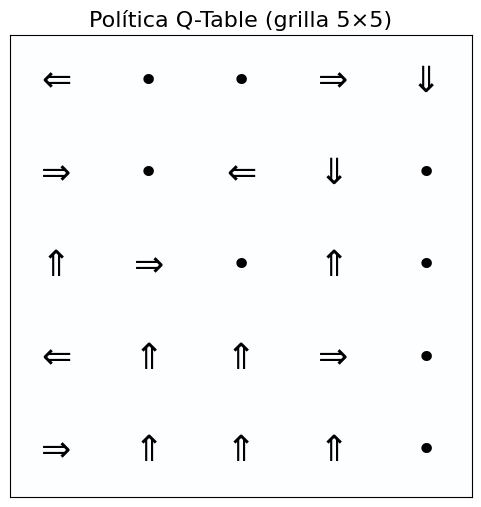

In [ ]:
policy_q = [
    np.argmax(agente_q._get_Q(s))
    for s in list(agente_q.Q.keys())[:25]
]
visualizar_politica_merge(policy_q, "Política Q-Table (grilla 5×5)")

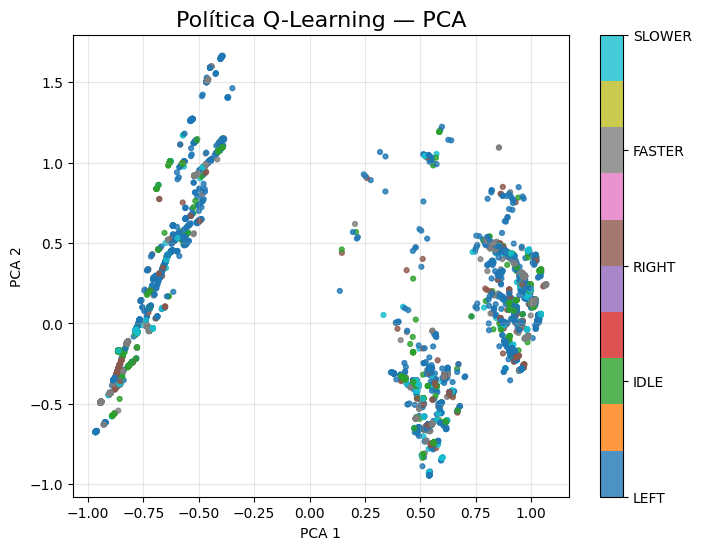

In [ ]:
visualizar_politica_pca(
    agente_q.estados_tomados,
    agente_q.acciones_tomadas,
    "Política Q-Learning — PCA"
)


Si bien el rendimiento de la tabla q es peor que la política aleatoria, en este gráfico se puede ver como las acciones no están tan mezcladas, lo que me hace pensar que la tabla q intenta aprender patrones.

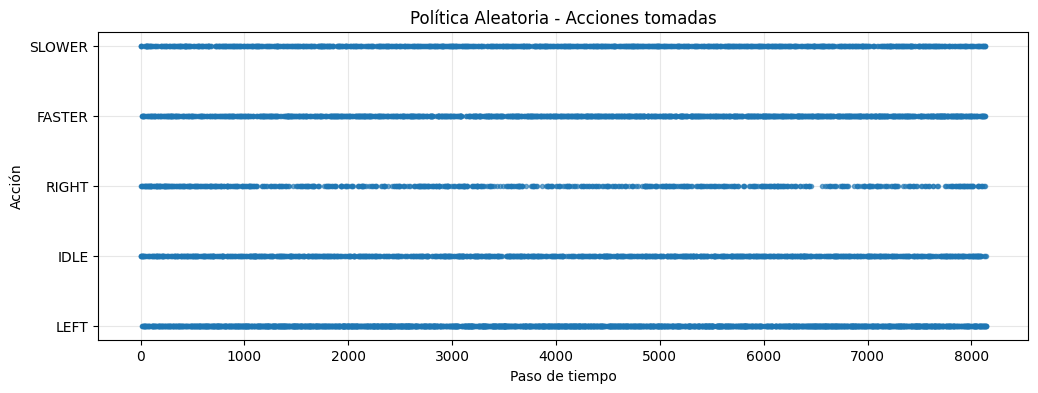

In [ ]:
PoliticaAleatoria.plot_politica_aleatoria_tiempo(agente_q.acciones_tomadas)

Este gráfico si es muy similar a la política aleatoria ya que se muestra como ejecuta todas las acciones por igual.

## Política Deep Q-Learning

Para relizar esta política me base en el tutorial de pytorch: https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
y también en el tp4 de frozen lake.

Con ayuda de chatGPT lo adaté al entorno de merge-v0.

Este bloque se encuentra en el tutorial de pytorch y se usa para empaquetar cada experiencia del agente en el entorno. La transción agrupa en una sola unidad los elementos fundamentales de un paso de aprendizaje en DQN, estado, acción, recompensa, siguiente estado y flag de finalización.
Esto permite almacenar, manipular y muestrear experiencias desde el replay buffer durante el entrenmaiento y hace que el agente pueda entrenar con minibatches desordesordenades, lo que estabiliza el aprendizaje en el entorno continuo de merge.

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Una transición estilo Transition(state, action, reward, next_state, done)."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        muestras = random.sample(self.memory, batch_size)
        return Transition(*zip(*muestras))

    def __len__(self):
        return len(self.memory)



La red neuronal esta basada en el tp4 de frozenlake.

In [ ]:
class DQNMergeNet(nn.Module):
    def __init__(self, input_size, output_size, hidden=128):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_size)
        )

    def forward(self, x):
        return self.network(x)



La configuración del agente DQN está con los mismo valores que se encuentran en el siguiente tutotiral: https://highway-env.farama.org/quickstart/ donde define un modelo DQN apto para los entorno de highway env.

También utilicé el tutorial de pytorch para seguir con la configuración, y traté de hacer la arquitectura similar al tp4: https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html.

In [ ]:
class DQNAgentMerge_Tutorial:
    def __init__(self,
                 state_size,
                 action_size,
                 gamma=0.99,
                 lr=1e-3,
                 epsilon=1.0,
                 epsilon_min=0.05,
                 epsilon_decay=0.995,
                 memory_size=30000,
                 batch_size=64):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.lr = lr

        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.batch_size = batch_size

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("🔵 Usando:", self.device)

        # Redes
        self.policy_net = DQNMergeNet(state_size, action_size).to(self.device)
        self.target_net = DQNMergeNet(state_size, action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        # Replay memory
        self.memory = ReplayMemory(memory_size)

        # Métricas
        self.losses = []
        self.rew_history = []
        self.success_history = []
        self.epsilon_history = []
        self.pasos_history = []

        # Logging PCA
        self.estados = []
        self.acciones = []

        self.steps_total = 0
        self.target_update_every = 1000

    # -----------------------
    def seleccionar_accion(self, state, train=True):
        if train and random.random() < self.epsilon:
            return random.randrange(self.action_size)

        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return q_values.argmax().item()

    # -----------------------
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*transitions)

        # Convertir batch a tensores
        state_batch = torch.FloatTensor(batch.state).to(self.device)
        action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(self.device)
        reward_batch = torch.FloatTensor(batch.reward).to(self.device)
        next_state_batch = torch.FloatTensor(batch.next_state).to(self.device)
        done_batch = torch.BoolTensor(batch.done).to(self.device)

        # Q(s,a)
        q_values = self.policy_net(state_batch).gather(1, action_batch).squeeze()

        # Q-target
        with torch.no_grad():
            next_q = self.target_net(next_state_batch).max(1)[0]
            target = reward_batch + self.gamma * next_q * (~done_batch)

        loss = F.mse_loss(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.losses.append(loss.item())

    # -----------------------
    def entrenar(self, env, episodios=1000, max_steps=200):
        print("\n🚀 Entrenando DQNl...")

        for ep in range(episodios):

            obs, info = env.reset(seed=SEED + ep)
            state = procesar_obs(obs)

            done = False
            total_r = 0
            pasos = 0
            crashed = False

            while not done and pasos < max_steps:

                self.estados.append(state)

                action = self.seleccionar_accion(state, train=True)
                self.acciones.append(action)

                next_obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                crashed = info.get("crashed", crashed)

                next_state = procesar_obs(next_obs)

                # Guardar transición estilo tutorial
                self.memory.push(state, action, reward, next_state, done)

                # Optimización del modelo
                self.optimize_model()

                state = next_state
                total_r += reward
                pasos += 1
                self.steps_total += 1

                # Actualizar target net
                if self.steps_total % self.target_update_every == 0:
                    self.target_net.load_state_dict(self.policy_net.state_dict())

            # Métricas por episodio
            self.rew_history.append(total_r)
            self.success_history.append(0 if crashed else 1)
            self.epsilon_history.append(self.epsilon)
            self.pasos_history.append(pasos)

            # Epsilon decay
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            if (ep + 1) % 200 == 0:
                print(f"Episodio {ep+1} | Éxito = {np.mean(self.success_history[-200:]):.2f} | Eps = {self.epsilon:.3f} | Loss = {np.mean(self.losses[-200:]):.4f}")

        print("\n✅ Entrenamiento DQN (tutorial) completado.")

    # -----------------------
    def evaluar(self, env, episodios=100, max_steps=200):
        print("\n📊 Evaluando DQN en modo greedy...")

        old_eps = self.epsilon
        self.epsilon = 0.0  # greedy

        exitos = 0
        recomp = []

        for ep in range(episodios):

            # SEMILLA FIJA POR EPISODIO
            obs, info = env.reset(seed=SEED + 5000 + ep)
            state = procesar_obs(obs)

            done = False
            total_r = 0
            crashed = False
            pasos = 0

            while not done and pasos < max_steps:
                action = self.seleccionar_accion(state, train=False)
                next_obs, reward, terminated, truncated, info = env.step(action)

                crashed = info.get("crashed", crashed)
                done = terminated or truncated

                state = procesar_obs(next_obs)
                total_r += reward
                pasos += 1

            recomp.append(total_r)
            if not crashed:
                exitos += 1

            # PRINT prolijo cada 20 episodios
            if (ep + 1) % 20 == 0:
                print(f"   Evaluación {ep+1}/{episodios} | R={np.mean(recomp):.2f} | Éxito={exitos/(ep+1):.3f}")

        self.epsilon = old_eps

        print("\n===== RESULTADOS =====")
        print(f"✔ Tasa de éxito final: {exitos/episodios:.3f}")
        print(f"✔ Recompensa promedio final: {np.mean(recomp):.3f}")

        return np.array(recomp)


In [ ]:
# Crear agente DQN para merge-v0
dqn_agent = DQNAgentMerge_Tutorial(state_size=env.observation_space.shape[0]*env.observation_space.shape[1], action_size=env.action_space.n)

# Función de preprocesamiento de observaciones (definida fuera de la clase para evitar NameError)
def procesar_obs(obs_raw):
    return obs_raw.flatten()

# ENTRENAMIENTO
dqn_agent.entrenar(
env=env,
    episodios=1000,
    max_steps=200
)

# EVALUACIÓN (política greedy)
dqn_agent.evaluar(
    env=env,
    episodios=100,
    max_steps=200
)

🔵 Usando: cuda

🚀 Entrenando DQNl...
Episodio 200 | Éxito = 0.15 | Eps = 0.367 | Loss = 0.0735
Episodio 400 | Éxito = 0.68 | Eps = 0.135 | Loss = 0.2375
Episodio 600 | Éxito = 0.91 | Eps = 0.050 | Loss = 0.2765
Episodio 800 | Éxito = 0.94 | Eps = 0.050 | Loss = 0.2980
Episodio 1000 | Éxito = 0.95 | Eps = 0.050 | Loss = 0.2711

✅ Entrenamiento DQN (tutorial) completado.

📊 Evaluando DQN en modo greedy...
   Evaluación 20/100 | R=13.80 | Éxito=1.000
   Evaluación 40/100 | R=13.68 | Éxito=1.000
   Evaluación 60/100 | R=13.76 | Éxito=1.000
   Evaluación 80/100 | R=13.69 | Éxito=1.000
   Evaluación 100/100 | R=13.69 | Éxito=1.000

===== RESULTADOS =====
✔ Tasa de éxito final: 1.000
✔ Recompensa promedio final: 13.687


array([15.06868563, 12.16856193, 14.99484609, 15.09646341, 15.09646341,
       15.06868563, 15.02262387, 14.57845667, 12.40185294, 15.09646341,
       12.46527991, 14.77290111, 11.59637089, 12.03916683, 11.52253134,
       15.09646341, 11.59637089, 12.40972435, 15.09646341, 14.82817942,
       12.03916683, 11.52253134, 14.82845667, 14.80067889, 11.59637089,
       14.68956778, 15.09646341, 14.57845667, 12.04995838, 14.80067889,
       12.16856193, 14.38401222, 14.80067889, 11.44859817, 14.85461207,
       14.80067889, 15.06868563, 14.80067889, 11.52253134, 11.52253134,
       12.40185294, 14.80067889, 13.62198234, 14.49512333, 14.77290111,
       15.09646341, 12.04995838, 15.09646341, 11.59637089, 15.09646341,
       15.09646341, 14.80067889, 11.52253134, 14.82845667, 12.03916683,
       15.02262387, 13.62198234, 12.65127974, 14.77127874, 14.99484609,
       11.47637595, 12.03916683, 14.99484609, 14.80067889, 14.82845667,
       11.52253134, 13.5219874 , 15.12424119, 14.85461207, 15.04

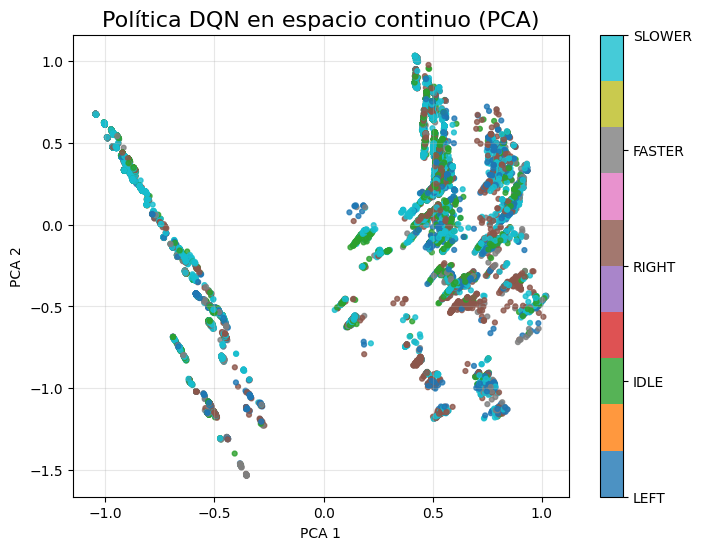

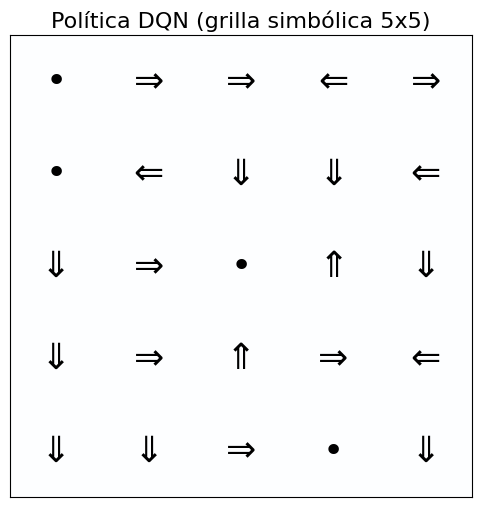

In [ ]:
# Visualización PCA en espacio continuo
visualizar_politica_pca(dqn_agent.estados,
                        dqn_agent.acciones,
                        title="Política DQN en espacio continuo (PCA)")


policy_25 = np.array(dqn_agent.acciones[:25])
visualizar_politica_merge(policy_25, title="Política DQN (grilla simbólica 5x5)")

El gráfico de PCA ya muestra como las acciones empiezan a agruparse, si bien no es una visiualización perfecta, comparado a los otros modelos se aprecia el aprendizaje de DQN.

## Gráficos finales y comparación de modelos

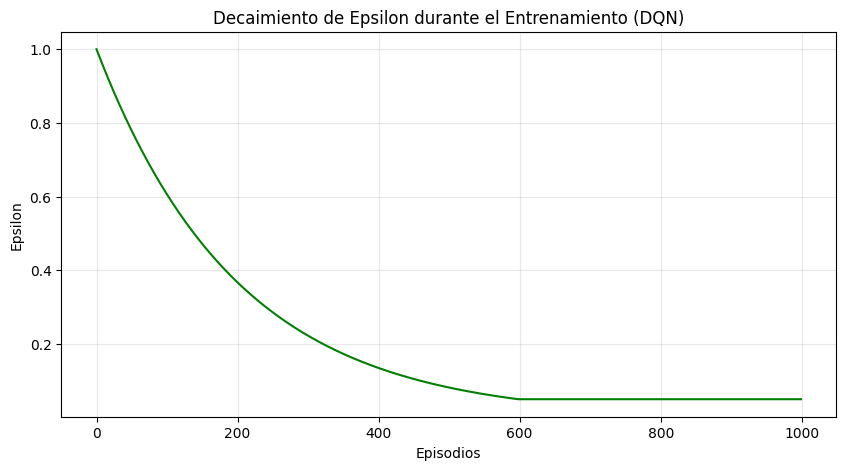

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(dqn_agent.epsilon_history, color="green")
plt.xlabel("Episodios")
plt.ylabel("Epsilon")
plt.title("Decaimiento de Epsilon durante el Entrenamiento (DQN)")
plt.grid(alpha=0.3)
plt.show()


Este gráfico muestra como para los primeros episodios, el modelo DQN explora mucho y luego va disminuyendo esa exploración hasta el episodio 600, donde se "estanca". Esto no quiere decir que esté mal, sino que el modelo ya aprendió correctamente el entorno y no necesita seguir explorándolo. El gráfico permite entender porqué el modelo DQN tuvo una tasa de éxito tan perfecta.

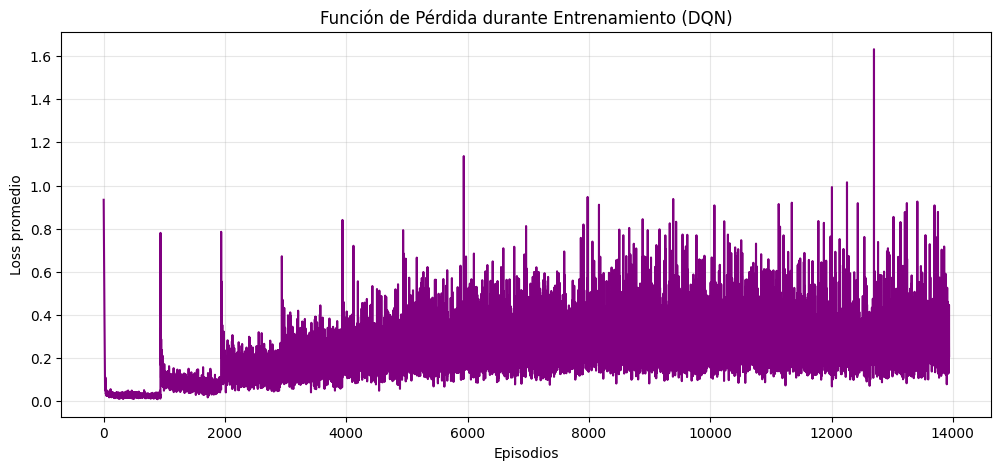

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(dqn_agent.losses, color='purple')
plt.xlabel("Episodios")
plt.ylabel("Loss promedio")
plt.title("Función de Pérdida durante Entrenamiento (DQN)")
plt.grid(alpha=0.3)
plt.show()

El modelo DQN comienza con una pérdida baja porque al inicio del entrenamiento, la red principal y la red objetivo están sincronizadas y la memoria de experiencia contiene transiciones simples y similares.
A medida que el entrenamiento avanza en el entorno continuo los estados cambian de forma constante y presentan mucha variabilidad. Esto provoca oscilaciones en la función de pérdida, lo cual es normal en DQN.

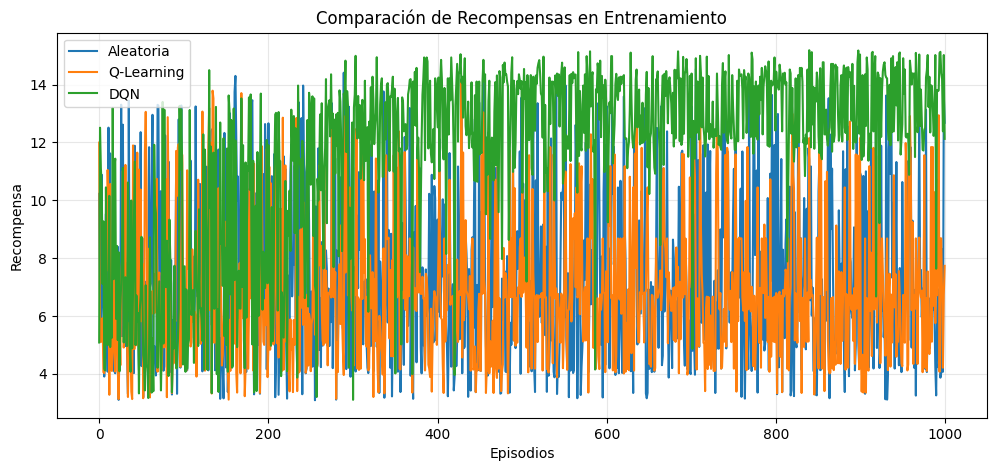

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(politica_aleatoria.recompensas_entrenamiento, label="Aleatoria")
plt.plot(agente_q.recompensas_entrenamiento, label="Q-Learning")
plt.plot(dqn_agent.rew_history, label="DQN") # Corregido: usar rew_history
plt.xlabel("Episodios")
plt.ylabel("Recompensa")
plt.title("Comparación de Recompensas en Entrenamiento")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

El grafico permite ver la evolución de recompensas a lo largo de los episodios. En este caso los tres modelos comienzan similar, pero el modelo DQN es quien obtiene mayor recompensa y presenta una estabilidad mayor.

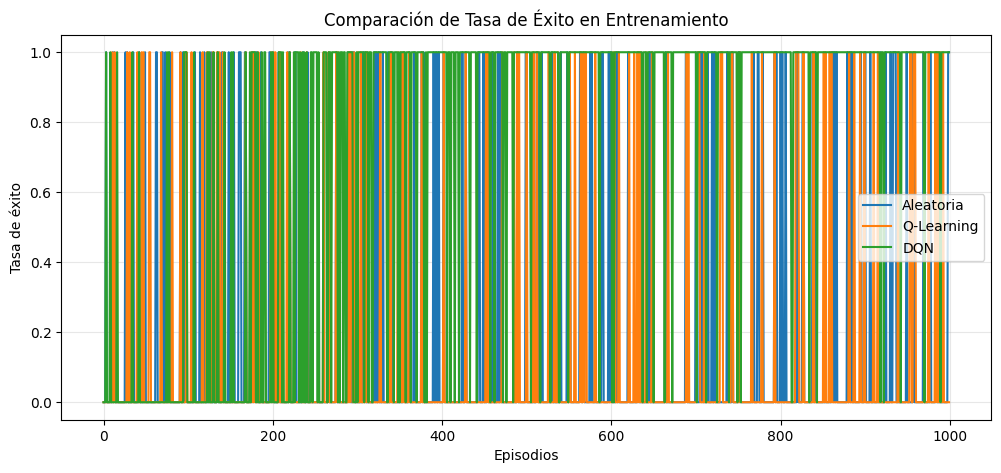

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(politica_aleatoria.exitos_entrenamiento, label="Aleatoria")
plt.plot(agente_q.exitos_entrenamiento, label="Q-Learning")
plt.plot(dqn_agent.success_history, label="DQN") # Corregido: usar success_history
plt.xlabel("Episodios")
plt.ylabel("Tasa de éxito")
plt.title("Comparación de Tasa de Éxito en Entrenamiento")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

El gráfco sigue mostrando la diferencia de rendimiento en los tres modelos, siengo DQN el que más éxito obtiene.

## Conclusiones

En esta trabajo tuve que implementar tres modelos de aprendizaje por refuerzo para entornos continuos: política aleatoria, Q learning tabular y DQN.

Utlizando el entorno merge, realicé las adaptaciones y los cambios necesarios del tp4 de frozenlake, ennumerándolos:

* En frozenlake habían 16 estados determinados, en merge hay infinitos estados dentro de una matriiz 5x5.
* Para la tabla Q, tuve que discretizar los números para que el modelo pueda interpretar a merge.
* En DQN, implementé la transición para estabilizar el modelo, además use una configuración de DQN especial para los entornos de highway env.

Los resultados de los modelos fueron un poco similares al tp4:

* La política aleatoria sigue sin ser buena opción para el aprendizaje por refuerzo, porque no tiene capacidad alguna de aprender.
* La tabla Q me sorprendió al tener un rendimiento tan bajo, creo que se debe a que es un modelo que no esta hecho para los entornos continuos, ya que en el entorno estático de frozenlake tuve un muy buen rendimiento, pero con merge fue incluso más bajo que la política aleatoria.
* DQN demostró ser un modelo super eficiente y estable para entornos continuos, pudiendo aprender y lograr una tasa de éxito del 100%.

Los resultados finales me hacen comprender que DQN es la mejor opción tanto para entornos estáticos como continuos, sin obviar que la tabla q sigue siendo buena con entornos estáticos.

En cuánto a mi experiencia personal, este fue el trabajo que más tiempo me llevo, me costó entender mucho el cambio entre entornos continuos y entornos estáticos. También tuve muchos problemas con el tiempo de ejecución de cada modelo, si había algún error en las celdas tenía que carmbiarlo y volver a ejecutar el código, lo que me llevaba muchísimo tiempo, aún usando la GPU.


## Referencias:

* Todas las clases de la materia referidas a aprendizaje por refuerzo.
* El tp4 de FrozenLake.
* https://highway-env.farama.org/quickstart/
* https://highway-env.farama.org/environments/merge/
* https://phuijse.github.io/MachineLearningBook/contents/reinforcement_learning/qlearning2.html
* https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* ChatGPT para entender conceptos que no conocía, y para adaptar los códigos a este trabajo.